### Import libraries 

In [1]:
import cv2 as OpenCV
import numpy as np
import os
from matplotlib import pyplot as plt

### Helper functions


In [2]:
def displayImage(image, title = None):
    if image.ndim == 2:
        plt.gray()
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.show()

# OpenCV use BGR format for reading images as it's default 
# to get RGB images we need to change the format 
def readImageRGB(imagePath):
    return OpenCV.cvtColor(OpenCV.imread(imagePath), OpenCV.COLOR_BGR2RGB)

def RGBtoGRAY(images):
    return [OpenCV.cvtColor(image, OpenCV.COLOR_RGB2GRAY) for image in images]

### Read all images from file into an array: images

In [3]:
def readImages(folderPath):
    files = sorted(os.listdir(folderPath))
    return [
        readImageRGB(f"{folderPath}/{file}")
        for file in files
        if ".jpg" in file
    ]

images = readImages("../src/images/snow-man/")


### Get gray images

In [4]:
grayImages = RGBtoGRAY(images)

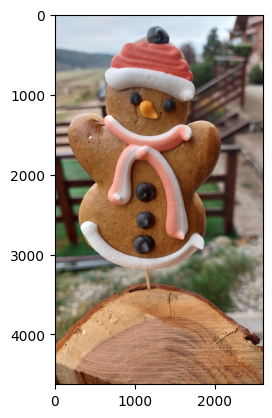

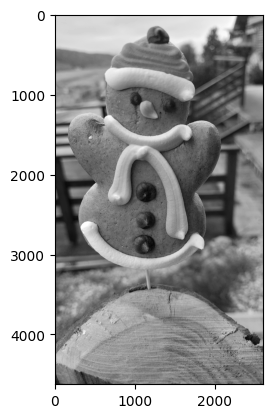

In [5]:
displayImage(images[0])
displayImage(grayImages[0])

## Feature Extraction
### Get **SIFT** keypoints & descriptors on single image

In [6]:
SIFT = OpenCV.SIFT_create()

def getSiftKeypoints(imageIndex):
    keyPoint, descriptor = SIFT.detectAndCompute(grayImages[imageIndex], None)
    return keyPoint, descriptor

### Get **MSER** keypoints & descriptors on all images

In [7]:
MSER = OpenCV.MSER_create()

def getMserKeypoints(imageIndex):
    keyPoint = MSER.detect(grayImages[imageIndex], None)
    descriptor = MSER.compute(grayImages[imageIndex], keyPoint)
    return keyPoint, descriptor

### Draw the keypoints 

In [8]:
def drawKeypoints(images, grayImages, keyPoints, method = "SIFT"):
    for i in range(len(images)):
        img = OpenCV.drawKeypoints(grayImages[i], keyPoints[i], images[i], flags = OpenCV.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
        OpenCV.imwrite(f"keyPoints/{method}/{str(i)}.jpg", img)

### Get keypoints & descriptors for all images

In [9]:
def getAllImagesKeyPoints(images, method = "SIFT"):
    keyPoints = []
    descriptors = []
    for i in range(len(images)):
        if method == "SIFT":
            keyPoint, descriptor = getSiftKeypoints(i)
        elif method == "MSER":
            keyPoint, descriptor = getMserKeypoints(i)
        keyPoints.append(np.array(keyPoint))
        descriptors.append(np.array(descriptor))
    return keyPoints, descriptors


### SIFT keypoints & descriptors on all images

In [10]:
SkeyPoints, Sdescriptors = getAllImagesKeyPoints(images, "SIFT")

### ⛔️ MSER keypoints & descriptors on all images
still have error in this part (most likely due to the gpu type used )
try to run it on a different machine

In [ ]:
# MkeyPoints, Mdescriptors = getAllImagesKeyPoints(images, "MSER")

### Draw keypoints for all images (SIFT)

In [ ]:
if (not os.path.exists("keyPoints")):
    os.mkdir("keyPoints")
if (not os.path.exists("keyPoints/SIFT")):
    os.mkdir("keyPoints/SIFT")

drawKeypoints(images, grayImages, SkeyPoints, "SIFT")

### ⛔️ Draw keypoints for all images (MSER)


In [ ]:
# if (not os.path.exists("keyPoints")):
#     os.mkdir("keyPoints")
# if (not os.path.exists("keyPoints/MSER")):
#     os.mkdir("keyPoints/MSER")

# drawKeypoints(images, grayImages, MkeyPoints, "MSER")

## Image Matching

In [ ]:
allDescriptors = []
for descriptors in Sdescriptors:
    allDescriptors.extend(iter(descriptors))
allDescriptors = np.stack(allDescriptors)

### Create clusters from descriptors using **Kmeans** 
#### don't run this, load the file only


In [ ]:
# from scipy.cluster.vq import kmeans

# clusters = 400
# iter = 2
# centroids, variance = kmeans(allDescriptors, clusters, iter)

KeyboardInterrupt: 

### Save the centroids for later use intstead of training multiple times


In [ ]:
# import joblib
# joblib.dump((clusters,centroids), "centroids.pkl", compress = 3)

['centroids.pkl']

### Load the file that stores the centroids


In [ ]:
import joblib
clusters, centroids = joblib.load("centroids.pkl")

### Create the visualWords 
⛔️ Make sure to run **getSiftKeypoints** first

In [ ]:
from scipy.cluster.vq import vq

visualWords = []
for descriptors in Sdescriptors:
    words, _ = vq(descriptors, centroids)
    visualWords.append(words)

### Calculate the frequency of each word

In [ ]:
frequency_vectors = []
for img_words in visualWords:
    histogram = np.zeros(clusters)
    for word in img_words:
        histogram[word] += 1
    frequency_vectors.append(histogram)

frequency_vectors = np.stack(frequency_vectors)

### Plot the frequency of words

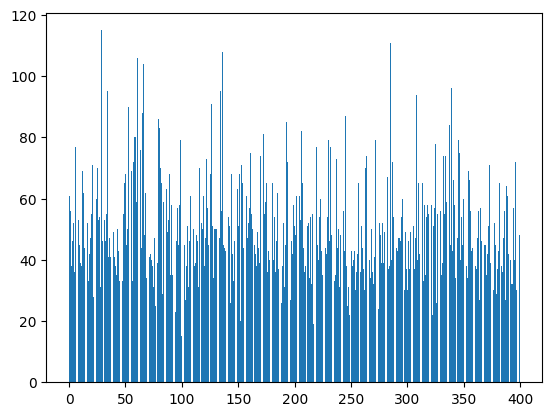

In [ ]:
plt.bar(list(range(clusters)), frequency_vectors[100])
plt.show()

### **TFIDF**: get the visual words that does that most effect

In [ ]:
n = len(images)

df = np.sum(frequency_vectors > 0, axis = 0)
idf = np.log(n/df)
tfidf = frequency_vectors * idf

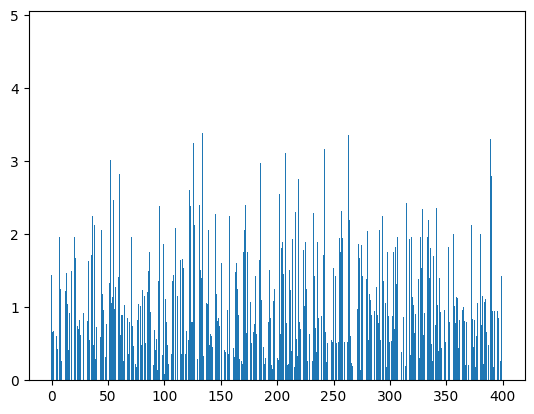

In [ ]:
plt.bar(list(range(clusters)), tfidf[100])
plt.show()

### Scoring and searching for image matches

In [ ]:
from numpy.linalg import norm
b = tfidf
def search_display(i: int, top_clusters: int = 5):

    print("Search image:")
    # show the search image
    displayImage(images[i])
    print("-----------------------------------------------------")

    a = tfidf[i]
    cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
    idx = np.argsort(-cosine_similarity)[:top_clusters]
    # display the results

    for i in idx:
        print(f"{str(i)}: {str(cosine_similarity[i])}")
        displayImage(images[i])

In [ ]:
b = tfidf
# def search(i: int, top_clusters: int = 5):
#     a = tfidf[i]
#     cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
#     idx = np.argsort(-cosine_similarity)[:top_clusters]
#     return idx
def search(i: int, top_clusters: int = 5):
    a = tfidf[i]
    b_subset = b[:tfidf.shape[0]]  # ensure b has the same number of rows as tfidf
    cosine_similarity = np.dot(a, b_subset.T)/(norm(a) * norm(b_subset, axis=1))
    idx = np.argsort(-cosine_similarity)[:top_clusters]
    # group index and similarity together in a tuple
    return list(zip(idx, cosine_similarity[idx]))

Search image:


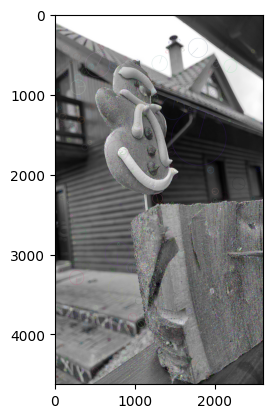

-----------------------------------------------------
8: 1.0


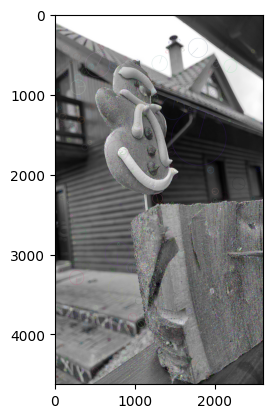

76: 0.9815351150429862


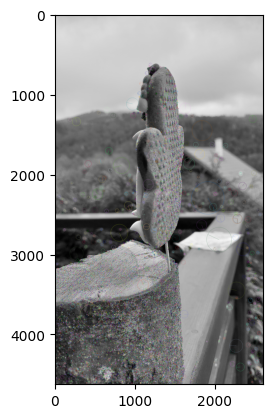

46: 0.9804294957327907


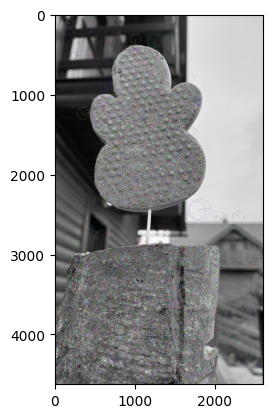

59: 0.978170137197577


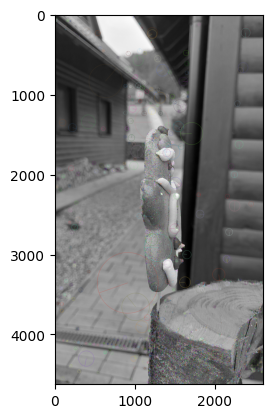

73: 0.9756064181629671


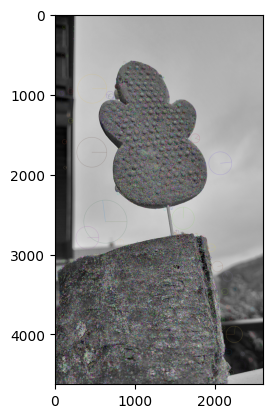

146: 0.9740170356223349


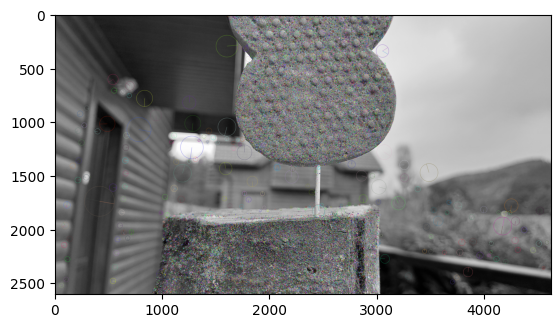

36: 0.9705089920670024


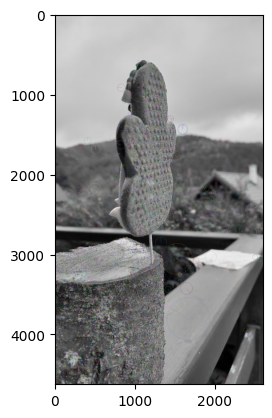

100: 0.9696454499142965


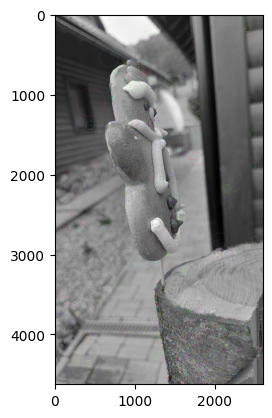

32: 0.9694861149613954


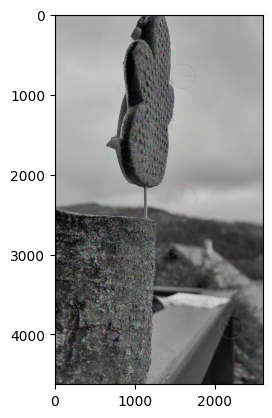

37: 0.9693512238978733


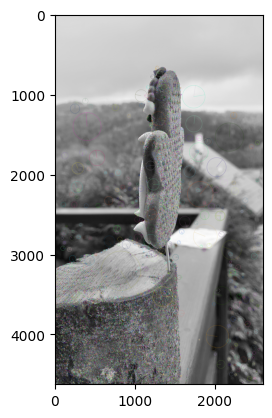

164: 0.9666738547152091


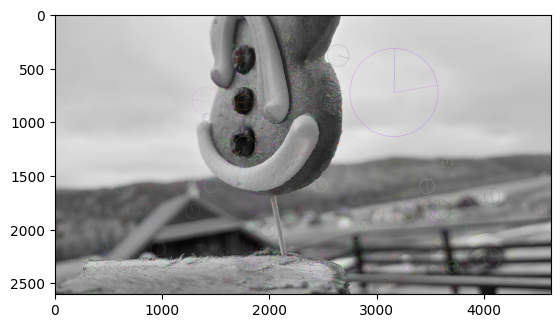

138: 0.9665943723511707


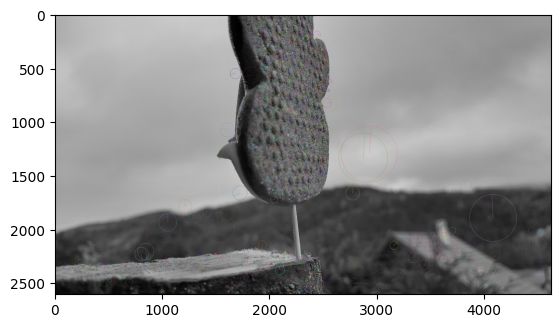

35: 0.9660586795719236


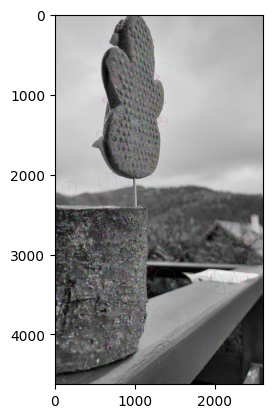

29: 0.9651499582313029


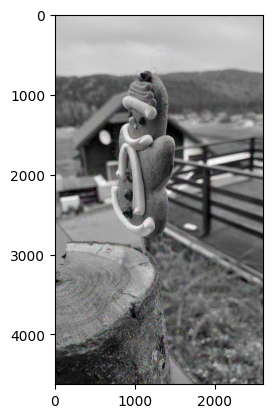

169: 0.9650668237213416


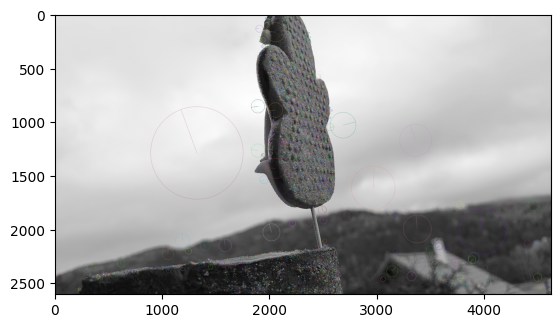

150: 0.9648541039978888


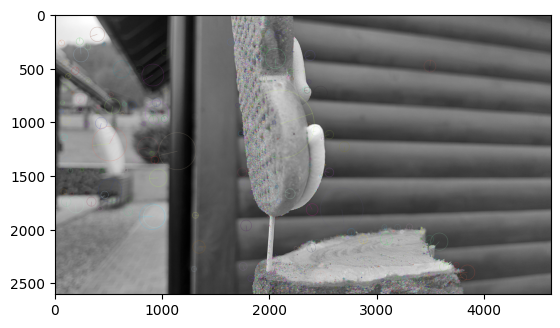

72: 0.963500122481224


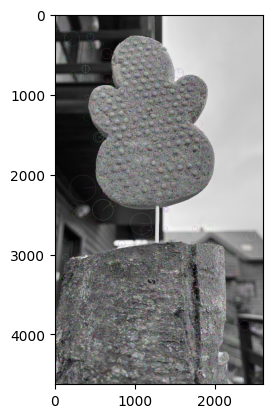

149: 0.9634120751478686


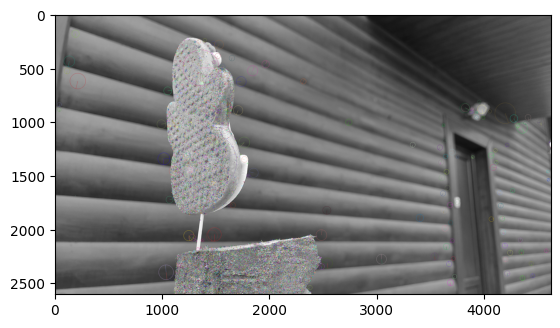

58: 0.963348134923932


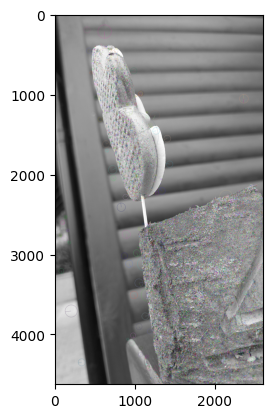

71: 0.9632208798946018


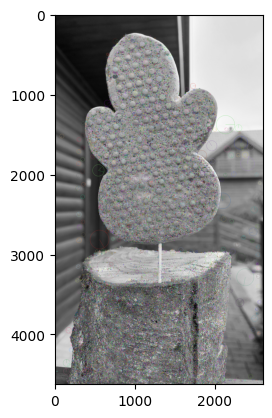

64: 0.9617229203116933


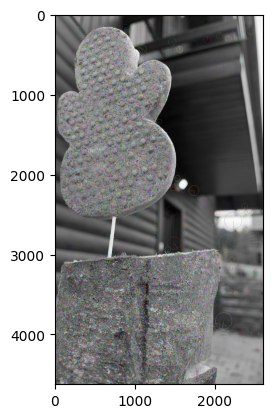

148: 0.961633878794545


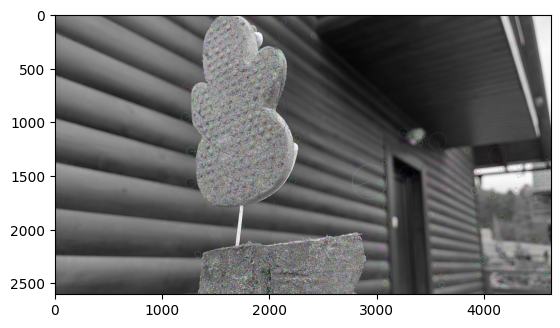

74: 0.9600496834651417


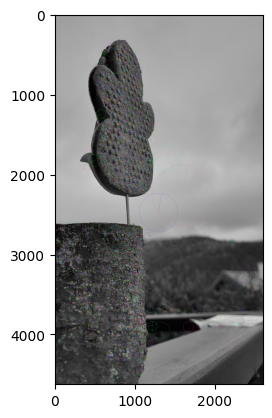

63: 0.9599955311913148


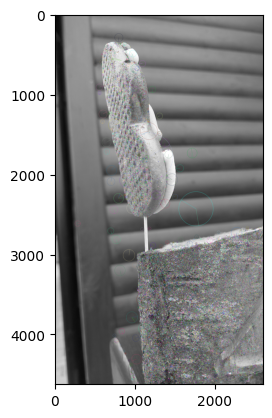

47: 0.9596154235663016


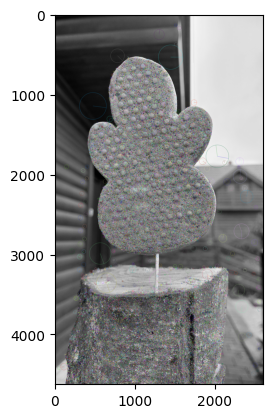

28: 0.9587452997853865


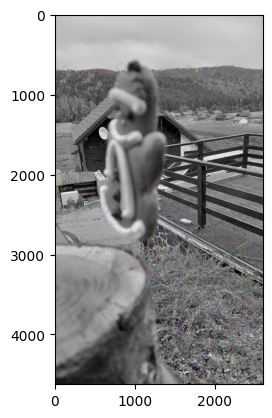

151: 0.95855214504875


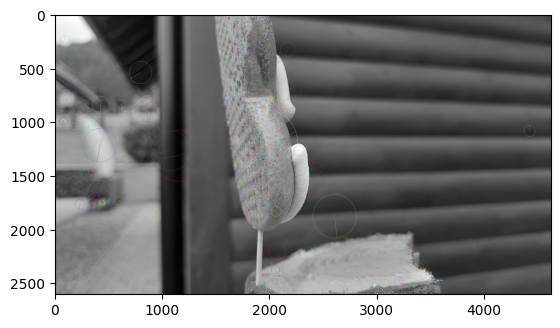

145: 0.9577234868483905


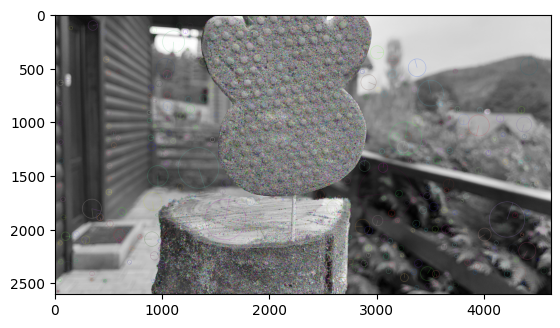

53: 0.9566360089924812


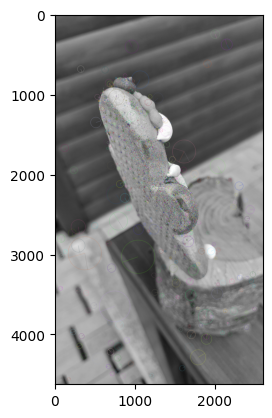

30: 0.9539943896009451


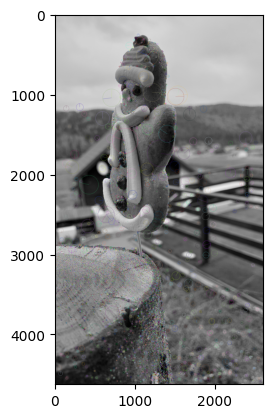

In [ ]:
search_display(8,10)

### Get the best 30 matches for all images

In [ ]:
matchesIDs = [search(i, 10) for i in range(len(images))]
print(*matchesIDs[0])


(0, 1.0000000000000002) (20, 0.9742561375975979) (19, 0.9732512231925257) (1, 0.9717184174644693) (85, 0.9708268993464938) (170, 0.9703484541278026) (2, 0.9659003935095279) (4, 0.9636930544170748) (91, 0.9626225275951561) (143, 0.9606704853854147)


## Feature Matching
### Get the matching features between 2 images

In [ ]:
def featureMatching(imgID1, imgID2, Sdescriptors):
    matcher = OpenCV.BFMatcher()
    return matcher.match(Sdescriptors[imgID1], Sdescriptors[imgID2])

In [ ]:
match = featureMatching(0, 1, Sdescriptors)

## Match all images

In [ ]:
def processMatches(matches):
        matches = sorted(matches, key = lambda x:x.distance)
        return matches[:int(len(matches)*0.2)]

In [ ]:
import logging
import time
# Initialize loging to file tune.log in current directory
logging.basicConfig(filename='tune.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info('Hello, world!')
def dataFeatureMatching(matchesIDs, Sdescriptors):
    num_images = len(Sdescriptors)
    checked = np.zeros((num_images, num_images), dtype=int)
    matches_list = []
    for imageID in range(len(matchesIDs)):
        logging.info(f"---------- START Matches for: {str(imageID)}")
        for i, (matchedID, probability) in enumerate(matchesIDs[imageID]):
            if ((checked[imageID][matchedID] == 0 or checked[matchedID][imageID] == 0) and imageID != matchedID and probability > 0.93):
                start_time = time.time()
                matches_list.append([imageID, matchedID, featureMatching(imageID, matchedID, Sdescriptors)])
                checked[imageID][matchedID], checked[matchedID][imageID] = 1, 1
                logging.info(f"done [{i}/{len(matchesIDs[imageID])}] in {(time.time() - start_time):.4f}: {str(imageID)} - {str(matchedID)}")
        # Flush the log file force write to disk
        logging.shutdown()
        # print(f"---------- DONE Matches for: {str(imageID)}")
    return matches_list

featuresMatches = dataFeatureMatching(matchesIDs, Sdescriptors)

KeyboardInterrupt: 

In [ ]:
import pickle

In [ ]:
# Save featuresMatches to file
with open('featuresMatches.pkl', 'wb') as f:
    pickle.dump(featuresMatches, f)

In [ ]:
# Load featuresMatches from file
with open('featuresMatches.pkl', 'rb') as f:
    featuresMatches = pickle.load(f)